In [98]:
import networkx as nx
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from synthetic_networks.random_network import *
from synthetic_networks.bba import *
from synthetic_networks.bba_homophily import *
from synthetic_networks.dpah import *
import itertools
from data_loader import *
from fast_pagerank import pagerank_power
import random
from collections import Counter
import pickle
from numpy import inf

import os
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
from joblib import delayed
from joblib import Parallel
from collections import Counter
from fast_pagerank import pagerank_power


# sns.set()

In [2]:
# G = DPAH(N=10000, 
#              fm=0.2, 
#              d=0.001,
#              plo_M=2.5, 
#              plo_m=2.5, 
#              h_MM=0.8, 
#              h_mm=0.2, 
#              verbose=False)

In [12]:
# num_nodes, min-maj split, homophily maj, homophily min
nx.write_gpickle(G, config.ROOT+'nx_DPAH_10000_0208_0802.pkl')

### Analysis

In [100]:
BIGNET = 11000
EXT = '.gpickle'
TOPK = 3

def _ppr(node_index, A, p, top):
    pp = np.zeros(A.shape[0])
    pp[node_index] = A.shape[0]
    pr = pagerank_power(A, p=p, personalize=pp)
    pr = pr.argsort()[-top-1:][::-1]
    #time.sleep(0.01)
    return pr[pr!=node_index][:top]

def get_circle_of_trust_per_node(A, p=0.85, top=10, num_cores=40):
    return Parallel(n_jobs=num_cores)(delayed(_ppr)(node_index, A, p, top) for node_index in np.arange(A.shape[0]))

def frequency_by_circle_of_trust(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    results = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [ 0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def _salsa(node_index, cot, A, top=10):
    BG = nx.Graph()
    BG.add_nodes_from(['h{}'.format(vi) for vi in cot], bipartite=0)  # hubs
    edges = [('h{}'.format(vi), int(vj)) for vi in cot for vj in np.argwhere(A[vi,:] != 0 )[:,1]]
    BG.add_nodes_from(set([e[1] for e in edges]), bipartite=1)  # authorities
    BG.add_edges_from(edges)
    centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                       and n not in cot
                                                                                       and n != node_index
                                                                                       and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })
    del(BG)
    #time.sleep(0.01)
    return np.asarray([n for n, pev in centrality.most_common(top)])[:top]

def frequency_by_who_to_follow(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def frequency_by_who_to_follow2(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    # del(results)
    return results

def who_to_follow_rank(A, njobs=1):
    if A.shape[0] < BIGNET:
        return wtf_small(A, njobs)
    else:
        # TODO: implement optimal (or faster) solution for big net
        return wtf_small(A, njobs)
        
def wtf_small(A, njobs):
    # utils.printf('cot_per_node...')
    cot_per_node = get_circle_of_trust_per_node(A, p=0.85, top=TOPK, num_cores=njobs)

    # utils.printf('cot...')
    cot = frequency_by_circle_of_trust(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)

    # utils.printf('wtf...')
    wtf = frequency_by_who_to_follow2(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)
    return wtf

In [3]:
def twitter_wtf(network, sparse_adj, node_id, k_for_circle_of_trust=20, cot_factor= 0.05, tol=1e-8,
                damping_factor=.85, k_for_recommendation=-1):
    """This method aims to realize a link prediction algorithm used by Twitter to perform
        the WTF recommendation on the platform.
        The algorithm can be seen at 'https://web.stanford.edu/~rezab/papers/wtf_overview.pdf'.
        The algorithm consists of two phases:
            1) Compute the circle of trust for the user you want to recommend(top-k nodes in PPR)
            2) Compute the top-k nodes using score propagation
    """
    k_for_circle_of_trust = min(int(network.number_of_nodes()*cot_factor), k_for_circle_of_trust)
    #1st phase: Compute circle of trust of user according to Personalized PageRank
    personalize = np.zeros(shape=network.number_of_nodes())
    personalize[node_id] = 1
    values_of_personalized_pr = pagerank_power(sparse_adj, p=damping_factor, personalize=personalize, tol=1e-6)
    circle_of_trust = values_of_personalized_pr.argsort()[-k_for_circle_of_trust:][::-1]

    #2nd phase: init bipartite graph
    bipartite_graph = nx.DiGraph()
    #add nodes belonging to the circle of trust as hubs(H)
    for node in circle_of_trust:
        #these nodes are "hubs"(H) in the bipartite graph
        bipartite_graph.add_node(str(node)+"H")
    #add out neighbors of nodes belonging to the circle of trust as authorities(A)
    for node in circle_of_trust:
        for out_neighbor in network.neighbors(node):
            #direction is inverted for a matter of simplicity in the sequent phases
            bipartite_graph.add_edge(str(out_neighbor)+"A", str(node)+"H")

    #retrieve adjacency matrix of bipartite graph
    A = nx.to_numpy_array(bipartite_graph)

    #retrieve list of all nodes splitted by authority or hub
    all_nodes = list(bipartite_graph.nodes())
    hub_nodes = [int(x[:-1]) for x in all_nodes if 'H' in x]
    authority_nodes = [int(x[:-1]) for x in all_nodes if 'A' in x]

    #3rd phase: start building ingredients of our SALSA algorithm
    #these are the transition matrices determined by the bipartite graph
    S_prime = A[len(hub_nodes):, :][:, :len(hub_nodes)].copy()
    R_prime = S_prime.T.copy()
    #normalize both matrices
    denominator_S_prime = S_prime.sum(axis=0)
    denominator_S_prime[denominator_S_prime == 0] = 1
    S_prime = S_prime / denominator_S_prime
    denominator_R_prime = R_prime.sum(axis=0)
    denominator_R_prime[denominator_R_prime == 0] = 1
    R_prime = R_prime / denominator_R_prime
    #these are the vectors which contain the score of similarity
    #and relevance
    s = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    r = np.zeros(shape=(len(authority_nodes), 1), dtype=np.float)

    #at the beginning of the procedure we put the similarity
    #of the user we want to give the recommendation equal to 1
    index_of_node_to_recommend = np.where(circle_of_trust == node_id)[0][0]
    s[index_of_node_to_recommend] = 1.

    #init damping vector
    alpha = 1 - damping_factor
    alpha_vector = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    alpha_vector[index_of_node_to_recommend] = alpha

    #4th phase: run the algorithm
    convergence = False
    while not convergence:
        s_ = s.copy()
        r_ = r.copy()
        r_ = S_prime.dot(s)
        s_ = alpha_vector + (1 - alpha)*(R_prime.dot(r))
        #compute difference and check if convergence has been reached
        diff = abs(s_ - s)
        if np.linalg.norm(diff) < tol:
            convergence=True
        #update real vectors
        s = s_
        r = r_

    #5th phase: order by score and delete neighbors of node to be recommended
    #of course we don't want to recommend people that the user already follow
    neighbors_to_not_recommend = nx.neighbors(network, node_id)
    relevance_scores = r.flatten()
    if k_for_recommendation == -1:
        k_for_recommendation = 0 #Take all the nodes!

    neighbors_to_not_recommend = set(neighbors_to_not_recommend)
    results = []
    for node in relevance_scores.argsort()[::-1]:
        if node not in neighbors_to_not_recommend and node != node_id:
            results.append(((node_id, node))) # , relevance_scores[node]
            if len(results) == k_for_recommendation:
                break
    return results

In [111]:
class Analyzer:

    def __init__(self, network, class_name='m', min_label=1, maj_label=0):
        self.network = network
        self.min_label, self.maj_label = min_label, maj_label
        # self.min_nodes, self.maj_nodes = self.get_nodes_per_class()
        # self.post_network = None
        self.class_name = class_name
        self.metrics_dict = {}
    
    def get_nodes_per_class(self, network):
        
        # class_
        if self.class_name == 'm':
            min_nodes_ig = network.vs.select(m=self.min_label)
            maj_nodes_ig = network.vs.select(m=self.maj_label)

        elif self.class_name == 'class_':
            min_nodes_ig = network.vs.select(class_=self.min_label)
            maj_nodes_ig = network.vs.select(class_=self.maj_label)
        
        elif self.class_name == 'age':
            min_nodes_ig = network.vs.select(age=self.min_label)
            maj_nodes_ig = network.vs.select(age=self.maj_label)

        return min_nodes_ig, maj_nodes_ig
    
    def get_group_betweenness(self, network, is_pre=True, verbose=True):

        min_nodes, maj_nodes = self.get_nodes_per_class(network)

        bc_full = network.betweenness(directed=True)
        network.vs['bc'] = bc_full

        min_bc = np.average(np.array(min_nodes.get_attribute_values('bc')))
        maj_bc = np.average(np.array(maj_nodes.get_attribute_values('bc')))
        
        if is_pre:
            self.metrics_dict['bc'] = {'pre': {}, 'post': {}}
            self.metrics_dict['bc']['pre'] = {'min': min_bc, 'maj': maj_bc}
        else:
            self.metrics_dict['bc']['post'] = {'min': min_bc, 'maj': maj_bc}

        if verbose:
            print(f"Minority BC: {min_bc}")
            print(f"Majority BC: {maj_bc}")

        return min_bc, maj_bc
    
    def get_group_closeness(self, network, is_pre=True, verbose=True):

        min_nodes, maj_nodes = self.get_nodes_per_class(network)

        cc_full = network.closeness()
        network.vs['cc'] = cc_full

        min_cc = np.average(np.array(min_nodes.get_attribute_values('cc')))
        maj_cc = np.average(np.array(maj_nodes.get_attribute_values('cc')))

        if is_pre:
            self.metrics_dict['cc'] = {'pre': {}, 'post': {}}
            self.metrics_dict['cc']['pre'] = {'min': min_cc, 'maj': maj_cc}
        else:
            self.metrics_dict['cc']['post'] = {'min': min_cc, 'maj': maj_cc}

        if verbose:
            print(f"Minority CC: {min_cc}")
            print(f"Majority CC: {maj_cc}")

        return min_cc, maj_cc
    
    def get_group_eigenvector_centrality(self, network, is_pre=True, verbose=True):

        min_nodes, maj_nodes = self.get_nodes_per_class(network)

        evc_full = network.eigenvector_centrality()
        network.vs['evc'] = evc_full

        min_evc = np.average(np.array(min_nodes.get_attribute_values('evc')))
        maj_evc = np.average(np.array(maj_nodes.get_attribute_values('evc')))
        
        if is_pre:
            self.metrics_dict['evc'] = {'pre': {}, 'post': {}}
            self.metrics_dict['evc']['pre'] = {'min': min_evc, 'maj': maj_evc}
        else:
            self.metrics_dict['evc']['post'] = {'min': min_evc, 'maj': maj_evc}

        if verbose:
            print(f"Minority EVC: {min_evc} / normalized: {min_evc/(min_evc+maj_evc)}")
            print(f"Majority EVC: {maj_evc} / normalized: {maj_evc/(min_evc+maj_evc)}")

        return min_evc, maj_evc
    
    def get_group_degree_centrality(self, network, is_pre=True, verbose=True):

        min_nodes, maj_nodes = self.get_nodes_per_class(network)
        all_ids = list(min_nodes) + list(maj_nodes)

        dc_full = network.degree(vertices=all_ids, mode='in')
        network.vs['dc'] = dc_full

        min_dc = np.average(np.array(min_nodes.get_attribute_values('dc')))
        maj_dc = np.average(np.array(maj_nodes.get_attribute_values('dc')))
        
        if is_pre:
            self.metrics_dict['dc'] = {'pre': {}, 'post': {}}
            self.metrics_dict['dc']['pre'] = {'min': min_dc, 'maj': maj_dc}
        else:
            self.metrics_dict['dc']['post'] = {'min': min_dc, 'maj': maj_dc}

        if verbose:
            print(f"Minority DC: {min_dc}")
            print(f"Majority DC: {maj_dc}")

        return min_dc, maj_dc
    
    def remove_zero_degree(self, verbose=False):
        self.to_remove = [node for node, degree in dict(self.network.degree()).items() if degree < 1]
        self.network.remove_nodes_from(self.to_remove)

        if verbose:
            print(f"Removed {len(self.to_remove)} nodes with degree zero.")
        return self.to_remove

    def add_nodes(self):
        self.network.add_nodes_from(self.to_remove)
        # print(f"Added {len(self.to_remove)} nodes.")

    def sample_and_delete_edges(self, num_to_sample=100, remove_edges=True):
        edge_list = list(self.network.edges())

        self.random_edges_to_delete = random.sample(edge_list, num_to_sample)
        nodes_with_del_out_edge = [tup[0] for tup in self.random_edges_to_delete]
        self.unique_nodes = list(set(nodes_with_del_out_edge))

        self.nodes_with_edge_count = Counter(node for node in nodes_with_del_out_edge)

        if remove_edges:
            self.network.remove_edges_from(self.random_edges_to_delete)

            # print(f'# nodes with deleted out edge {len(nodes_with_del_out_edge)}')
            print(f'# unique nodes with deleted out edge: {len(self.unique_nodes)}')
        else:
            print(f'# unique nodes with sampled out edge: {len(self.unique_nodes)} - No edges where deleted.')

        return self.random_edges_to_delete, self.unique_nodes, self.nodes_with_edge_count

    def reconstruct_edges(self, strategy='bulk', k_for_circle_of_trust=20, salsa_new=True):
    
        if strategy == 'consecutively':
            self.salsa_edges_per_node = {}
            self.salsa_all_edges = []
            self.top_10pct_frac_min = []
            self.edge_type = {'mm': 0,
                            'MM': 0,
                            'mM': 0,
                            'Mm': 0}
            num_edges_added = 0
            for node in self.unique_nodes:
                self.salsa_edges_per_node[node] = []
                for k in range(self.nodes_with_edge_count[node]):

                    if salsa_new:
                        wtf = who_to_follow_rank(A=nx.adjacency_matrix(self.network))
                        wtf_node_i = list(wtf[node])
                        pick = random.choice(wtf_node_i)[0]
                        self.network.add_edge(node, pick)

                        top_10_classes = [self.network.nodes()[node][self.class_name] for node in wtf_node_i]
                        frac_min = sum(top_10_classes) / len(top_10_classes)
                        frac_maj = 1-frac_min
                        self.top_10pct_frac_min.append(frac_min)

                        self.salsa_edges_per_node[node].append(pick)
                        self.salsa_all_edges.append(pick)
                        
                        num_edges_added += 1
                        print(f'num edges added: {num_edges_added}')


                    else:
                        top_all = twitter_wtf(network=self.network, sparse_adj=nx.adjacency_matrix(self.network), node_id=node, k_for_recommendation=-1)
                        top_1 = top_all[0]
                        self.network.add_edge(node, top_1[1])
                        
                        top_10pct = top_all[:int(len(top_all)*0.1)]
                        top_10pct_classes = [self.network.nodes()[edge[1]][self.class_name] for edge in top_10pct]
                        frac_min = sum(top_10pct_classes) / len(top_10pct_classes)
                        frac_maj = 1-frac_min
                        self.top_10pct_frac_min.append(frac_min)

                        self.salsa_edges_per_node[node].append(top_1)
                        self.salsa_all_edges.append(top_1)
                        
                        num_edges_added += 1
                
            for k in self.salsa_edges_per_node.keys():
                class_k = self.network.nodes()[k][self.class_name]
                for j in self.salsa_edges_per_node[k]:
                    class_j = self.network.nodes()[j[-1]][self.class_name]

                    if class_k == 1 and class_j == 1:
                        self.edge_type['mm'] += 1
                    elif class_k == 1 and class_j == 0:
                        self.edge_type['mM'] += 1
                    elif class_k == 0 and class_j == 1:
                        self.edge_type['Mm'] += 1
                    elif class_k == 0 and class_j == 0:
                        self.edge_type['MM'] += 1


            self.avg_frac_min, self.sd_frac_min = np.round(np.average(self.top_10pct_frac_min), 5), np.round(np.std(self.top_10pct_frac_min), 5)



        elif strategy == 'bulk':
            self.salsa_edges_per_node = {}
            self.salsa_all_edges = []
            num_edges_added = 0
            for node in self.unique_nodes:

                recommended_nodes = twitter_wtf(network=self.network, sparse_adj=nx.adjacency_matrix(self.network), node_id=node, k_for_circle_of_trust=k_for_circle_of_trust, k_for_recommendation=self.nodes_with_edge_count[node])
                self.network.add_edges_from(recommended_nodes)
                self.salsa_edges_per_node[node] = recommended_nodes
                self.salsa_all_edges.append(recommended_nodes[0])
                num_edges_added += len(recommended_nodes)
        
        elif strategy == 'random':
            self.salsa_edges_per_node = {}
            self.salsa_all_edges = []
            num_edges_added = 0
            self.all_nodes = list(self.network.nodes())
            for node in self.unique_nodes:
                
                for i in range(self.nodes_with_edge_count[node]):
                    pick = random.sample(self.all_nodes, 1)[0]

                    self.network.add_edge(node, pick)
                    self.salsa_edges_per_node[node] = pick
                    self.salsa_all_edges.append(pick)
                    num_edges_added += 1

        self.overlap = len(list(set(self.random_edges_to_delete) & set(self.salsa_all_edges))) / len(self.random_edges_to_delete)
        # print(f'Added {num_edges_added} edges.')
        # print(f'Overlap SALSA <> deleted edges: {self.overlap}')

        return self.salsa_edges_per_node, self.salsa_all_edges, self.overlap, self.edge_type, self.avg_frac_min

    def add_edges(self, strategy='bulk', k_for_circle_of_trust=20):

        if strategy == 'bulk':
            self.salsa_edges_per_node = {}
            self.salsa_all_edges = []
            num_edges_added = 0
            for node in self.unique_nodes:

                recommended_nodes = twitter_wtf(network=self.network, sparse_adj=nx.adjacency_matrix(self.network), node_id=node, k_for_circle_of_trust=k_for_circle_of_trust, k_for_recommendation=self.nodes_with_edge_count[node])
                self.network.add_edges_from(recommended_nodes)
                self.salsa_edges_per_node[node] = recommended_nodes
                self.salsa_all_edges.append(recommended_nodes[0])
                num_edges_added += len(recommended_nodes)

        elif strategy == 'random':
            self.salsa_edges_per_node = {}
            self.salsa_all_edges = []
            num_edges_added = 0
            self.all_nodes = list(self.network.nodes())
            for node in self.unique_nodes:
                
                for z in range(self.nodes_with_edge_count[node]):
                    pick = random.sample(self.all_nodes, 1)[0]

                    self.network.add_edge(node, pick)
                    self.salsa_edges_per_node[node] = pick
                    self.salsa_all_edges.append(pick)
                    num_edges_added += 1
        
        return self.salsa_edges_per_node, self.salsa_all_edges
        

    def get_metrics_report(self):
        
        for metric in self.metrics_dict.keys():
            print("")
            print(f"{metric} Evaluation")
            print("------------------------")

            for stage in self.metrics_dict[metric].keys():
                print("")
                print(f"{stage} intervention")
                print("---------------------")
                print(f"Ratio min/maj values: {self.metrics_dict[metric][stage]['min']/self.metrics_dict[metric][stage]['maj']}")
                print("---------------------")
            print("------------------------")

    def get_relative_metric_changes(self, metric='all', round=5):

        if metric == 'all':
           
            bc_vals = self.metrics_dict['bc']
            print("Relative BC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((bc_vals['post']['maj']/bc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((bc_vals['post']['min']/bc_vals['pre']['min']-1)*100, round)}%")
            print("")
        
            cc_vals = self.metrics_dict['cc']
            print("Relative CC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((cc_vals['post']['maj']/cc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((cc_vals['post']['min']/cc_vals['pre']['min']-1)*100, round)}%")
            print("")
        
            evc_vals = self.metrics_dict['evc']
            print("Relative EVC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((evc_vals['post']['maj']/evc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((evc_vals['post']['min']/evc_vals['pre']['min']-1)*100, round)}%")
            # print(f"Normalized Majority change (pre->post) %: {np.round(((evc_vals['post']['maj']/(evc_vals['post']['maj']+evc_vals['post']['min']))/(evc_vals['pre']['maj']/(evc_vals['pre']['maj']+evc_vals['pre']['min']))-1)*100)}%")
            # print(f"Normalized Minority change (pre->post) %: {np.round((evc_vals['post']['min']/(evc_vals['pre']['min']+evc_vals['pre']['maj'])-1)*100, round)}%")
            print("")

            dc_vals = self.metrics_dict['dc']
            print("Relative DC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((dc_vals['post']['maj']/dc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((dc_vals['post']['min']/dc_vals['pre']['min']-1)*100, round)}%")
            print("")

        elif metric == 'bc':
            bc_vals = self.metrics_dict['bc']

            print("Relative BC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((bc_vals['post']['maj']/bc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((bc_vals['post']['min']/bc_vals['pre']['min']-1)*100, round)}%")
        
        elif metric == 'cc':
            cc_vals = self.metrics_dict['cc']
            
            print("Relative CC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((cc_vals['post']['maj']/cc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((cc_vals['post']['min']/cc_vals['pre']['min']-1)*100, round)}%")
        
        elif metric == 'evc':
            evc_vals = self.metrics_dict['evc']
            
            print("Relative EVC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((evc_vals['post']['maj']/evc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((evc_vals['post']['min']/evc_vals['pre']['min']-1)*100, round)}%")
        
        elif metric == 'dc':
            dc_vals = self.metrics_dict['dc']
            
            print("Relative DC changes")
            print("---------------------------")
            print(f"Majority change (pre->post) %: {np.round((dc_vals['post']['maj']/dc_vals['pre']['maj']-1)*100, round)}%")
            print(f"Minority change (pre->post) %: {np.round((dc_vals['post']['min']/dc_vals['pre']['min']-1)*100, round)}%")

In [5]:
def nx_to_ig(G):
    return ig.Graph.from_networkx(G)

In [6]:
def rename_class_attribute(G, from_='', to_=''):
    class_ = G.vs()[from_]
    G.vs[to_] = class_

In [7]:
def remove_zero_degree(network, verbose=False):
    to_remove = [node for node, degree in dict(network.degree()).items() if degree < 1]
    network.remove_nodes_from(to_remove)

    if verbose:
        print(f"Removed {len(to_remove)} nodes with degree zero.")
    return to_remove

In [8]:
def sample_and_delete_edges(network, num_to_sample=100, remove_edges=True):
    
    edge_list = list(network.edges())

    random_edges_to_delete = random.sample(edge_list, num_to_sample)
    nodes_with_del_out_edge = [tup[0] for tup in random_edges_to_delete]
    nodes_with_del_out_edge.append(883)
    unique_nodes = list(set(nodes_with_del_out_edge))

    nodes_with_edge_count = Counter(node for node in nodes_with_del_out_edge)

    if remove_edges:
        network.remove_edges_from(random_edges_to_delete)

        print(f'# nodes with deleted out edge {len(nodes_with_del_out_edge)}')
        print(f'# unique nodes with deleted out edge: {len(unique_nodes)}')
    else:
        print(f'# unique nodes with sampled out edge: {len(unique_nodes)} - No edges where deleted.')

    return random_edges_to_delete, unique_nodes, nodes_with_edge_count

In [9]:
def reconstruct_edges(network, nodes_with_edge_count, k_for_circle_of_trust=20):
    salsa_edges_per_node = {}
    salsa_all_edges = []
    num_edges_added = 0
    for node in unique_nodes:

        recommended_nodes = twitter_wtf(network=network, sparse_adj=nx.adjacency_matrix(network), node_id=node, k_for_circle_of_trust=k_for_circle_of_trust, k_for_recommendation=nodes_with_edge_count[node])
        network.add_edges_from(recommended_nodes)
        salsa_edges_per_node[node] = recommended_nodes
        salsa_all_edges.append(recommended_nodes[0])
        num_edges_added += len(recommended_nodes)

    return salsa_edges_per_node, salsa_all_edges

In [112]:
def run_n_simulations(network_obj=None, network_file='', n=5, num_to_sample=10000, delete_edges=True, verbose=False, round=5, 
                      remove_zero_degree_nodes=True, class_name='m', min_label=1, maj_label=0,
                      strategy='bulk', save_results=True, save_as='', to_txt=True, salsa_new=True):

    

    changes_dict_min = {'bc': [],
                        'cc': [],
                        'evc': [],
                        'dc': [],
                        'c_coeff': [],
                        'aspl': []
                        }

    changes_dict_maj = {'bc': [],
                        'cc': [],
                        'evc': [],
                        'dc': [],
                        'c_coeff': [],
                        'aspl': []
                        }

    recommended_nodes_dict = {}

    edge_type_dict = {}

    frac_mins_list = []

    overlaps = []
    

    for i in range(n):

        if network_file == '':
            g = network_obj
        else:
            g = read_pkl_graph(network_file)
       
        g = reindex_nodes(g, name_as_str=False)

        a = Analyzer(network=g, class_name=class_name, min_label=min_label, maj_label=maj_label)

        if remove_zero_degree_nodes:
            _ = a.remove_zero_degree()

        if i == 0:
            min_c_coeff, maj_c_coeff = get_avg_clustering_coefficient(network_obj=a.network, mode='zero', class_name=class_name, group_names=[min_label, maj_label])
            min_aspl, maj_aspl = get_avg_sp_lengths(network_obj=a.network, mode='out', class_name=class_name, group_names=[min_label, maj_label])

        g_pre = nx_to_ig(a.network)

        _ = a.get_group_betweenness(g_pre, is_pre=True, verbose=verbose)
        _ = a.get_group_closeness(g_pre, is_pre=True, verbose=verbose)
        _ = a.get_group_eigenvector_centrality(g_pre, is_pre=True, verbose=verbose)
        _ = a.get_group_degree_centrality(g_pre, is_pre=True, verbose=verbose)

        if remove_zero_degree_nodes:
            if len(a.to_remove) > 0:
                a.add_nodes()
        _ = a.sample_and_delete_edges(num_to_sample=num_to_sample, remove_edges=delete_edges)

        # if remove_zero_degree_nodes:
        #     a.add_nodes_()

        if delete_edges:
            salsa_edges_per_node, salsa_all_edges, overlap, edge_type, avg_frac_min = a.reconstruct_edges(strategy=strategy, salsa_new=salsa_new)
        else:
            salsa_edges_per_node, salsa_all_edges = a.add_edges(strategy=strategy)

        edge_type_dict[i] = edge_type
        frac_mins_list.append(avg_frac_min)
        
        if remove_zero_degree_nodes:
            _ = a.remove_zero_degree()

        min_ccoeff_post, maj_ccoeff_post = get_avg_clustering_coefficient(network_obj=a.network, mode='zero', class_name=class_name, group_names=[min_label, maj_label])
        min_aspl_post, maj_aspl_post = get_avg_sp_lengths(network_obj=a.network, mode='out', class_name=class_name, group_names=[min_label, maj_label])

        changes_dict_maj['c_coeff'].append(np.round((maj_ccoeff_post/maj_c_coeff-1)*100, round))
        changes_dict_min['c_coeff'].append(np.round((min_ccoeff_post/min_c_coeff-1)*100, round))

        changes_dict_maj['aspl'].append(np.round((maj_aspl_post/maj_aspl-1)*100, round))
        changes_dict_min['aspl'].append(np.round((min_aspl_post/min_aspl-1)*100, round))

        g_post = nx_to_ig(a.network)

        _ = a.get_group_betweenness(g_post, is_pre=False, verbose=verbose)
        _ = a.get_group_closeness(g_post, is_pre=False, verbose=verbose)
        _ = a.get_group_eigenvector_centrality(g_post, is_pre=False, verbose=verbose)
        _ = a.get_group_degree_centrality(g_post, is_pre=False, verbose=verbose)
        
        bc_vals = a.metrics_dict['bc']
        changes_dict_maj['bc'].append(np.round((bc_vals['post']['maj']/bc_vals['pre']['maj']-1)*100, round))
        changes_dict_min['bc'].append(np.round((bc_vals['post']['min']/bc_vals['pre']['min']-1)*100, round))

        cc_vals = a.metrics_dict['cc']
        changes_dict_maj['cc'].append(np.round((cc_vals['post']['maj']/cc_vals['pre']['maj']-1)*100, round))
        changes_dict_min['cc'].append(np.round((cc_vals['post']['min']/cc_vals['pre']['min']-1)*100, round))

        evc_vals = a.metrics_dict['evc']
        norm_evc_min_pre = evc_vals['pre']['min'] / (evc_vals['pre']['min'] + evc_vals['pre']['maj'])
        norm_evc_maj_pre = evc_vals['pre']['maj'] / (evc_vals['pre']['min'] + evc_vals['pre']['maj'])

        norm_evc_min_post = evc_vals['post']['min'] / (evc_vals['post']['min'] + evc_vals['post']['maj'])
        norm_evc_maj_post = evc_vals['post']['maj'] / (evc_vals['post']['min'] + evc_vals['post']['maj'])

        changes_dict_maj['evc'].append(np.round((norm_evc_maj_post/norm_evc_maj_pre-1)*100, round))
        changes_dict_min['evc'].append(np.round((norm_evc_min_post/norm_evc_min_pre-1)*100, round))

        dc_vals = a.metrics_dict['dc']
        changes_dict_maj['dc'].append(np.round((dc_vals['post']['maj']/dc_vals['pre']['maj']-1)*100, round))
        changes_dict_min['dc'].append(np.round((dc_vals['post']['min']/dc_vals['pre']['min']-1)*100, round))

        recommended_nodes_dict[i] = salsa_all_edges
        overlaps.append(overlap)

        print(f'Finished run {i}')

    # return changes_dict_maj, changes_dict_min
    avg_bc_change_maj, sd_bc_maj = np.round(np.average(changes_dict_maj['bc']), round), np.round(np.std(changes_dict_maj['bc']), round)
    avg_bc_change_min, sd_bc_min = np.round(np.average(changes_dict_min['bc']), round), np.round(np.std(changes_dict_min['bc']), round)

    avg_cc_change_maj, sd_cc_maj = np.round(np.average(changes_dict_maj['cc']), round), np.round(np.std(changes_dict_maj['cc']), round)
    avg_cc_change_min, sd_cc_min = np.round(np.average(changes_dict_min['cc']), round), np.round(np.std(changes_dict_min['cc']), round)

    avg_evc_change_maj, sd_evc_maj = np.round(np.average(changes_dict_maj['evc']), round), np.round(np.std(changes_dict_maj['evc']), round)
    avg_evc_change_min, sd_evc_min = np.round(np.average(changes_dict_min['evc']), round), np.round(np.std(changes_dict_min['evc']), round)

    avg_dc_change_maj, sd_dc_maj = np.round(np.average(changes_dict_maj['dc']), round), np.round(np.std(changes_dict_maj['dc']), round)
    avg_dc_change_min, sd_dc_min = np.round(np.average(changes_dict_min['dc']), round), np.round(np.std(changes_dict_min['dc']), round)

    avg_ccoeff_change_maj, sd_ccoeff_maj = np.round(np.average(changes_dict_maj['c_coeff']), round), np.round(np.std(changes_dict_maj['c_coeff']), round)
    avg_ccoeff_change_min, sd_ccoeff_min = np.round(np.average(changes_dict_min['c_coeff']), round), np.round(np.std(changes_dict_min['c_coeff']), round)

    avg_aspl_change_maj, sd_aspl_maj = np.round(np.average(changes_dict_maj['aspl']), round), np.round(np.std(changes_dict_maj['aspl']), round)
    avg_aspl_change_min, sd_aspl_min = np.round(np.average(changes_dict_min['aspl']), round), np.round(np.std(changes_dict_min['aspl']), round)

    mm = []
    mM = []
    MM = []
    Mm = []

    for run in edge_type_dict.keys():
        mm.append(edge_type_dict[run]['mm'])
        mM.append(edge_type_dict[run]['mM'])
        MM.append(edge_type_dict[run]['MM'])
        Mm.append(edge_type_dict[run]['Mm'])

    mm = [m/num_to_sample for m in mm]
    mM = [m/num_to_sample for m in mM]
    MM = [m/num_to_sample for m in MM]
    Mm = [m/num_to_sample for m in Mm]

    avg_mm, sd_mm = np.round(np.average(mm), round), np.round(np.std(mm), round)
    avg_mM, sd_mM = np.round(np.average(mM), round), np.round(np.std(mM), round)
    avg_MM, sd_MM = np.round(np.average(MM), round), np.round(np.std(MM), round)
    avg_Mm, sd_Mm = np.round(np.average(Mm), round), np.round(np.std(Mm), round)

    avg_avg_frac_min, sd_frac_min = np.round(np.average(frac_mins_list), round), np.round(np.std(frac_mins_list), 5)
        

    if to_txt:
        save_as_txt = save_as[:-4] + '.txt'
        f = open(save_as_txt, 'w')

        f.write("\n")
        f.write(f"Mean stats and standard deviation for {n} runs\n")
        f.write("---------------------------------------------------\n")
        f.write("\n")
        f.write('Edge types\n')
        f.write("---------------------------\n")
        f.write(f'mm: {avg_mm}% ({sd_mm})\n')
        f.write(f'mM: {avg_mM}% ({sd_mM})\n')
        f.write(f'MM: {avg_MM}% ({sd_MM})\n')
        f.write(f'Mm: {avg_Mm}% ({sd_Mm})\n')
        f.write("\n")
        f.write('Top-10% Minority Fraction\n')
        f.write("---------------------------\n")
        f.write(f'Avg. minority fraction: {avg_avg_frac_min}% ({sd_frac_min})\n')
        f.write("\n")
        f.write('DC Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_dc_change_maj} ({sd_dc_maj})\n")
        f.write(f"Minority: {avg_dc_change_min} ({sd_dc_min})\n")
        f.write("\n")
        f.write('BC Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_bc_change_maj} ({sd_bc_maj})\n")
        f.write(f"Minority: {avg_bc_change_min} ({sd_bc_min})\n")
        f.write("\n")
        f.write('CC Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_cc_change_maj} ({sd_cc_maj})\n")
        f.write(f"Minority: {avg_cc_change_min} ({sd_cc_min})\n")
        f.write("\n")
        f.write('EVC Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_evc_change_maj} ({sd_evc_maj})\n")
        f.write(f"Minority: {avg_evc_change_min} ({sd_evc_min})\n")
        f.write("\n")
        f.write('Clustering Coeff Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_ccoeff_change_maj} ({sd_ccoeff_maj})\n")
        f.write(f"Minority: {avg_ccoeff_change_min} ({sd_ccoeff_min})\n")
        f.write("\n")
        f.write('Avg. Shortest Path Changes\n')
        f.write("---------------------------\n")
        f.write(f"Majority: {avg_aspl_change_maj} ({sd_aspl_maj})\n")
        f.write(f"Minority: {avg_aspl_change_min} ({sd_aspl_min})\n")
        f.write("\n")
        f.write(f"Avg. overlap: {np.round(np.average(overlaps), round)}\n")

        f.close()

    print("")
    print(f"Mean stats and standard deviation for {n} runs")
    print("---------------------------------------------------")
    print("")
    print('Edge types')
    print("---------------------------")
    print(f'mm: {avg_mm}% ({sd_mm})')
    print(f'mM: {avg_mM}% ({sd_mM})')
    print(f'MM: {avg_MM}% ({sd_MM})')
    print(f'Mm: {avg_Mm}% ({sd_Mm})')
    print("")
    print('Top-10% Minority Fraction')
    print("---------------------------")
    print(f'Avg. minority fraction: {avg_avg_frac_min}% ({sd_frac_min})')
    print("")
    print('DC Changes')
    print("---------------------------")
    print(f"Majority: {avg_dc_change_maj} ({sd_dc_maj})")
    print(f"Minority: {avg_dc_change_min} ({sd_dc_min})")
    print("")
    print('BC Changes')
    print("---------------------------")
    print(f"Majority: {avg_bc_change_maj} ({sd_bc_maj})")
    print(f"Minority: {avg_bc_change_min} ({sd_bc_min})")
    print("")
    print('CC Changes')
    print("---------------------------")
    print(f"Majority: {avg_cc_change_maj} ({sd_cc_maj})")
    print(f"Minority: {avg_cc_change_min} ({sd_cc_min})")
    print("")
    print('EVC Changes')
    print("---------------------------")
    print(f"Majority: {avg_evc_change_maj} ({sd_evc_maj})")
    print(f"Minority: {avg_evc_change_min} ({sd_evc_min})")
    print("")
    print('Clustering Coeff Changes')
    print("---------------------------")
    print(f"Majority: {avg_ccoeff_change_maj} ({sd_ccoeff_maj})")
    print(f"Minority: {avg_ccoeff_change_min} ({sd_ccoeff_min})")
    print("")
    print('Avg. Shortest Path Changes')
    print("---------------------------")
    print(f"Majority: {avg_aspl_change_maj} ({sd_aspl_maj})")
    print(f"Minority: {avg_aspl_change_min} ({sd_aspl_min})")
    print("")
    print(f"Avg. overlap: {np.round(np.average(overlaps), round)}")

    if save_results:
        results = {'pct_changes': {'min': changes_dict_min, 'maj': changes_dict_maj}, 'recommended_nodes': recommended_nodes_dict}
        with open(save_as, 'wb') as f:
            pickle.dump(results, f)
        print('')
        print(f'Results saved to disk as {save_as}')

    return {'min': changes_dict_min, 'maj': changes_dict_maj}, recommended_nodes_dict

            

In [11]:
# with open('dpah_salsa_edges/dpah_results_82.pkl', 'rb') as f:
#     nodes82 = pickle.load(f)['recommended_nodes']

# with open('dpah_salsa_edges/dpah_results_28.pkl', 'rb') as f:
#     nodes28 = pickle.load(f)['recommended_nodes']

# with open('dpah_salsa_edges/dpah_results_55.pkl', 'rb') as f:
#     nodes55 = pickle.load(f)['recommended_nodes']

# with open('dpah_salsa_edges/dpah_results_22.pkl', 'rb') as f:
#     nodes22 = pickle.load(f)['recommended_nodes']

# with open('dpah_salsa_edges/dpah_results_88.pkl', 'rb') as f:
#     nodes88 = pickle.load(f)['recommended_nodes']

In [12]:
def get_recommendation_group_ratios(network_file='', network_obj=None, recommended_nodes=[], class_name='m', deleted=True):
    
    if network_file == '':
        network = network_obj
    else:
        network = read_pkl_graph(network_file)

    all_nodes = network.nodes()
    shares_min = []
    shares_maj = []


    for i in recommended_nodes.keys():

        count_maj = 0
        count_min = 0
        
        if deleted:

            for tup in recommended_nodes[i]:
                node = tup[-1]
                if all_nodes[node][class_name] == 0:
                    count_maj += 1
                elif all_nodes[node][class_name] == 1:
                    count_min += 1
        
        else:
            for node in recommended_nodes[i]:
                
                if all_nodes[node][class_name] == 0:
                    count_maj += 1
                elif all_nodes[node][class_name] == 1:
                    count_min += 1

        shares_min.append(count_min/len(recommended_nodes[i]))
        shares_maj.append(count_maj/len(recommended_nodes[i]))

    avg_share_min = np.round(np.average(shares_min), 5)
    avg_share_maj = np.round(np.average(shares_maj), 5)

    print(f'avg. share of min: {avg_share_min} ({np.std(shares_min)})')
    print(f'avg. share of maj: {avg_share_maj} ({np.std(shares_maj)})')

    return {'min_prop': avg_share_min, 'maj_prop': avg_share_maj}

In [13]:
def get_avg_clustering_coefficient(network_file='', network_obj=None, mode='zero', class_name='m', group_names=[1, 0], verbose=True):

    def get_nodes_per_class(network, class_name='m', group_names=['young', 'old']):
        
        # class_
        if class_name == 'm':
            min_nodes_ig = network.vs.select(m=group_names[0])
            maj_nodes_ig = network.vs.select(m=group_names[-1])

        elif class_name == 'class_':
            min_nodes_ig = network.vs.select(class_=group_names[0])
            maj_nodes_ig = network.vs.select(class_=group_names[-1])

        elif class_name == 'age':
            min_nodes_ig = network.vs.select(age=group_names[0])
            maj_nodes_ig = network.vs.select(age=group_names[-1])

        return min_nodes_ig, maj_nodes_ig
    
    if network_file == '':
        network = network_obj
    else:
        network = read_pkl_graph(network_file)

    network_ig = nx_to_ig(network)

    min_nodes, maj_nodes = get_nodes_per_class(network_ig, class_name=class_name, group_names=group_names)

    # mode: how to treat nodes with degree < 2
    transitivity = network_ig.transitivity_local_undirected(mode=mode)
    network_ig.vs['clustering_coeff'] = transitivity

    min_clustering_coeff = np.average(np.array(min_nodes.get_attribute_values('clustering_coeff')))
    maj_clustering_coeff = np.average(np.array(maj_nodes.get_attribute_values('clustering_coeff')))

    if verbose:
        print(f'Min clustering coeff: {min_clustering_coeff}')
        print(f'Maj clustering coeff: {maj_clustering_coeff}')

    return min_clustering_coeff, maj_clustering_coeff
    

In [14]:
def get_avg_sp_lengths(network_file='', network_obj=None, mode='out', class_name='m', group_names=[1, 0], verbose=True):

    def get_nodes_per_class(network, class_name='m', group_names=['young', 'old']):
        
        # class_
        if class_name == 'm':
            min_nodes_ig = network.vs.select(m=group_names[0])
            maj_nodes_ig = network.vs.select(m=group_names[-1])

        elif class_name == 'class_':
            min_nodes_ig = network.vs.select(class_=group_names[0])
            maj_nodes_ig = network.vs.select(class_=group_names[-1])

        elif class_name == 'age':
            min_nodes_ig = network.vs.select(age=group_names[0])
            maj_nodes_ig = network.vs.select(age=group_names[-1])

        return min_nodes_ig, maj_nodes_ig
    
    if network_file == '':
        network = network_obj
    else:
        network = read_pkl_graph(network_file)
    network_ig = nx_to_ig(network)

    shortest_path_lengths = network_ig.shortest_paths(mode=mode)
    arr = np.array(shortest_path_lengths)
    arr[arr==inf] = 0
    avg_sp_lens = [np.average(lens) for lens in arr]

    min_nodes, maj_nodes = get_nodes_per_class(network_ig, class_name=class_name, group_names=group_names)

    network_ig.vs['avg_sp_len'] = avg_sp_lens

    min_avg_sp = np.average(np.array(min_nodes.get_attribute_values('avg_sp_len')))
    maj_avg_sp = np.average(np.array(maj_nodes.get_attribute_values('avg_sp_len')))

    if verbose:
        print(f'Min avg sp length: {min_avg_sp}')
        print(f'Maj avg sp length: {maj_avg_sp}')

    return min_avg_sp, maj_avg_sp


In [15]:
# changes82, recommended_nodes82 = run_n_simulations(network_file='nx_DPAH_10000_0208_0802.pkl', n=4, num_to_sample=10000, delete_edges=False, verbose=False, round=5, remove_zero_degree_nodes=True, class_name='m', strategy='bulk', save_results=True, save_as='dpah_results_82.pkl')

In [16]:
def plot_degree_dist_per_group(G, attribute='', group_names=['', ''], group_labels=[1, 0]):
    minority = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == group_labels[0]]
    majority = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == group_labels[1]]
    
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Degree distribution by group')
    
    sns.histplot(ax=ax[0], data=minority)
    # ax[0].set_ylabel('test')
    ax[0].set_xlabel('Degree')
    ax[0].set_title(f'{group_names[0]} (minority)')

    sns.histplot(ax=ax[1], data=majority)
    ax[1].set_xlabel('Degree')
    ax[1].set_title(f'{group_names[1]} (majority)')

    plt.show()

In [17]:
def get_group_ratios(network_obj, attribute='', group_names=['', ''], group_labels=[1, 0]):

    minority = [n for n in network_obj.nodes(data=True) if n[-1][attribute] == group_labels[0]]
    majority = [n for n in network_obj.nodes(data=True) if n[-1][attribute] == group_labels[1]]

    print(f'# {group_names[0]} nodes (minority): {len(minority)} ({np.round(len(minority)/(len(minority)+len(majority))*100, 2)}%)')
    print(f'# {group_names[1]} nodes (majority): {len(majority)} ({np.round(len(majority)/(len(minority)+len(majority))*100, 2)}%)')

In [18]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.histplot(degrees)
    plt.xlabel('Degree')
    plt.show()

In [19]:
def enum_vnum(network):
    print(f'Number of edges: {network.number_of_edges()}')
    print(f'Number of nodes: {network.number_of_nodes()}')

In [20]:
def reindex_nodes(network, name_as_str=True):

    old = list(network.nodes())
    new = list(range(0, len(old)))

    if name_as_str:
        old_str = [str(i) for i in old]
        mapping1 = dict(zip(old, old_str))
    else:
        mapping1 = dict(zip(old, old))
    nx.set_node_attributes(network, values=mapping1, name='name')

    mapping2 = dict(zip(old, new))

    return nx.relabel_nodes(network, mapping2, copy=True)

In [102]:
network = nx.read_gpickle(config.ROOT + 'nx_DPAH_10000_0208_0802.pkl')

In [104]:
enum_vnum(network)

Number of edges: 99990
Number of nodes: 10000


In [105]:
get_group_ratios(network, attribute='m', group_names=[1, 0], group_labels=[1, 0])

# 1 nodes (minority): 2000 (20.0%)
# 0 nodes (majority): 8000 (80.0%)


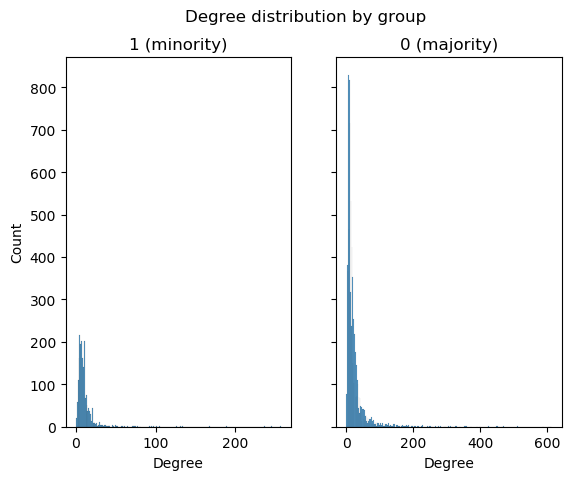

In [106]:
plot_degree_dist_per_group(network, attribute='m', group_names=[1, 0], group_labels=[1, 0])

In [113]:
sls_new_changes, sls_new_nodes = run_n_simulations(network_obj=network, n=2, 
                                            num_to_sample=2000, delete_edges=True, verbose=False, round=5, 
                                            remove_zero_degree_nodes=True, class_name='m', min_label=1, maj_label=0,
                                            strategy='consecutively', save_results=False, save_as='sls_new_results_test.pkl', 
                                            to_txt=True, salsa_new=True)

Min clustering coeff: 0.026287739520099357
Maj clustering coeff: 0.024368034087210763
Min avg sp length: 2.916731649489981
Maj avg sp length: 2.9252581868748875
# unique nodes with deleted out edge: 1652


KeyboardInterrupt: 

#### Pokec network analysis

In [22]:
pokec_sample = nx.read_gpickle(config.ROOT+'POKEC-A21/nx_pokec_sample_fabbri_netfile_relabeled_attributes.pkl')

##### Attach age data to nodes

In [23]:
pokec_nodes_age = pd.read_csv(config.ROOT+'POKEC-A21/graph_nodes_by_age.tsv', sep='\t')

In [24]:
node_ids_all = np.array(list(pokec_nodes_age['node']))
node_age_all = np.array(list(pokec_nodes_age['age']))

mapping_all = dict(zip(node_ids_all, node_age_all))

In [25]:
pokec_sample_nodes = np.array(list(pokec_sample.nodes()))

In [ ]:
id_list = []

for node in node_ids_all:

    if node in pokec_sample_nodes:
        id_list.append(node)
        if len(id_list) % 20000 == 0:
            print(len(id_list))

In [ ]:
age_list = []

for node in node_ids_all:

    if node in pokec_sample_nodes:
        age_list.append(mapping_all[node])
        if len(age_list) % 20000 == 0:
            print(len(age_list))

In [28]:
id_age_mapping = dict(zip(id_list, age_list))

In [29]:
nx.set_node_attributes(pokec_sample, values=id_age_mapping, name='age')

In [30]:
nx.write_gpickle(pokec_sample, config.ROOT+'POKEC-A21/nx_pokec_sample_fabbri_netfile_relabeled_attributes.pkl')

##### Network analysis

In [23]:
enum_vnum(pokec_sample)

Number of edges: 8635657
Number of nodes: 499051


In [ ]:
# out = [print(x) for x,y in pokec_sample.nodes(data=True) if 'age' not in y.keys()]

In [24]:
get_group_ratios(pokec_sample, attribute='age', group_names=['Young', 'Old'], group_labels=['young', 'old'])

# Young nodes (minority): 231408 (46.37%)
# Old nodes (majority): 267643 (53.63%)


In [24]:
prl = reindex_nodes(pokec_sample, name_as_str=True)

In [36]:
get_avg_clustering_coefficient(network_obj=prl, mode='zero', class_name='age', group_names=['young', 'old'])

Min clustering coeff: 0.10987223735893467
Maj clustering coeff: 0.10317896607116984


(0.10987223735893467, 0.10317896607116984)

In [ ]:
get_avg_sp_lengths(network_obj=prl, mode='out', class_name='age', group_names=['young', 'old'])

In [25]:
pokec_changes, pokec_nodes = run_n_simulations(network_obj=prl, n=3, 
                                            num_to_sample=20000, delete_edges=True, verbose=False, round=5, 
                                            remove_zero_degree_nodes=True, class_name='age', min_label='young', maj_label='old',
                                            strategy='bulk', save_results=True, save_as='pokec_results.pkl')

In [ ]:
get_recommendation_group_ratios(network_obj=prl,
                                recommended_nodes=pokec_nodes,
                                class_name='age',
                                deleted=True)

#### Blogs network analysis

In [29]:
blogs = nx.read_gpickle(config.ROOT + "blogs_attributed_network_anon.gpickle")

In [30]:
enum_vnum(blogs)

Number of edges: 19025
Number of nodes: 1224


In [31]:
get_group_ratios(blogs, attribute='m', group_names=['Left-leaning', 'Right-leaning'], group_labels=[1, 0])

# Left-leaning nodes (minority): 588 (48.04%)
# Right-leaning nodes (majority): 636 (51.96%)


In [ ]:
plot_degree_dist_per_group(blogs, attribute='m', group_names=['Left-leaning', 'Right-leaning'], group_labels=[1, 0])

In [33]:
brl = reindex_nodes(blogs, name_as_str=True)

In [85]:
get_avg_clustering_coefficient(network_obj=brl, mode='zero')

Min clustering coeff: 0.33135913459607913
Maj clustering coeff: 0.308981090896077


(0.33135913459607913, 0.308981090896077)

In [86]:
get_avg_sp_lengths(network_obj=brl, mode='out')

Min avg sp length: 2.2563136365657375
Maj avg sp length: 2.1872751983392935


In [34]:
def missing_elements(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

In [52]:
blogs_changes, blogs_nodes = run_n_simulations(network_obj=brl, n=2, 
                                            num_to_sample=2000, delete_edges=True, verbose=False, round=5, 
                                            remove_zero_degree_nodes=True, class_name='m', min_label=1, maj_label=0,
                                            strategy='consecutively', save_results=False, save_as='blogs_results_test.pkl', to_txt=True)

Min clustering coeff: 0.33135913459607913
Maj clustering coeff: 0.308981090896077
Min avg sp length: 2.2563136365657375
Maj avg sp length: 2.1872751983392935
# unique nodes with deleted out edge: 647
Min clustering coeff: 0.3275932043060467
Maj clustering coeff: 0.27609372900320067
Min avg sp length: 2.253908270913467
Maj avg sp length: 2.0868155377020816
Finished run 0
# unique nodes with deleted out edge: 656
Min clustering coeff: 0.3308862889760806
Maj clustering coeff: 0.2592904867115784
Min avg sp length: 2.2184090806847063
Maj avg sp length: 2.0529647298928277
Finished run 1

Mean stats and standard deviation for 2 runs
---------------------------------------------------

Edge types
---------------------------
mm: 0.4435% (0.006)
mM: 0.0295% (0.0045)
MM: 0.01725% (0.00125)
Mm: 0.50975% (0.00275)

Top-10% Minority Fraction
---------------------------
Avg. minority fraction: 0.92186% (0.00017)

DC Changes
---------------------------
Majority: -4.62284 (2.69786)
Minority: 2.63564 (1

In [97]:
get_recommendation_group_ratios(network_obj=brl,
                                recommended_nodes=blogs_nodes,
                                class_name='m',
                                deleted=False)

avg. share of min: 0.47895 (0.011604848124814035)
avg. share of maj: 0.52105 (0.011604848124814058)


{'min_prop': 0.47895, 'maj_prop': 0.52105}

#### Hate network analysis

In [ ]:
hate = nx.read_gpickle(config.ROOT + "hate_attributed_network_anon.gpickle")

In [90]:
enum_vnum(hate)

Number of edges: 15141
Number of nodes: 4971


In [91]:
get_group_ratios(hate, attribute='m', group_names=['Hateful', 'Normal'], group_labels=[1, 0])

# Hateful nodes (minority): 544 (10.94%)
# Normal nodes (majority): 4427 (89.06%)


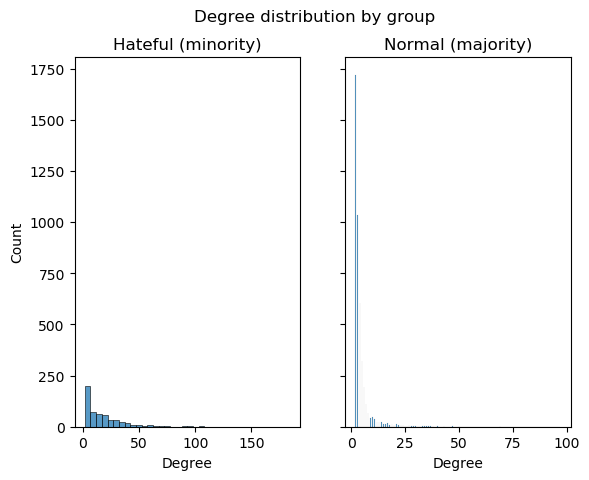

In [92]:
plot_degree_dist_per_group(hate, attribute='m', group_names=['Hateful', 'Normal'], group_labels=[1, 0])

In [71]:
# majority = [hate.degree(n[0]) for n in hate.nodes(data=True) if n[-1]['m'] == 0]

In [93]:
hrl = reindex_nodes(hate, name_as_str=True)

In [94]:
get_avg_clustering_coefficient(network_obj=hrl, mode='zero')

Min clustering coeff: 0.1469718722716244
Maj clustering coeff: 0.03689886088024183


(0.1469718722716244, 0.03689886088024183)

In [95]:
get_avg_sp_lengths(network_obj=hrl, mode='out')

Min avg sp length: 0.8473443767971884
Maj avg sp length: 0.19148040791549195


In [96]:
hate_changes, hate_nodes = run_n_simulations(network_obj=hrl, n=10, 
                                            num_to_sample=2000, delete_edges=True, verbose=False, round=5, 
                                            remove_zero_degree_nodes=True, class_name='m', min_label=1, maj_label=0,
                                            strategy='random', save_results=True, save_as='hate_results_random.pkl')

# unique nodes with deleted out edge: 1243
Finished run 0
# unique nodes with deleted out edge: 1227
Finished run 1
# unique nodes with deleted out edge: 1234
Finished run 2
# unique nodes with deleted out edge: 1232
Finished run 3
# unique nodes with deleted out edge: 1249
Finished run 4
# unique nodes with deleted out edge: 1230
Finished run 5
# unique nodes with deleted out edge: 1219
Finished run 6
# unique nodes with deleted out edge: 1247
Finished run 7
# unique nodes with deleted out edge: 1262
Finished run 8
# unique nodes with deleted out edge: 1228
Finished run 9

Mean % changes and standard deviation for 10 runs
---------------------------------------------------

BC Changes
---------------------------
Majority: 174.93867 (16.28949)
Minority: 234.75303 (13.75884)

CC Changes
---------------------------
Majority: nan (nan)
Minority: nan (nan)

EVC Changes
---------------------------
Majority: 72.43276 (4.93394)
Minority: -2.18838 (0.14907)

DC Changes
------------------------

In [99]:
get_recommendation_group_ratios(network_obj=hrl,
                                recommended_nodes=hate_nodes,
                                class_name='m',
                                deleted=False)

avg. share of min: 0.10965 (0.005500227268031747)
avg. share of maj: 0.89035 (0.005500227268031755)


{'min_prop': 0.10965, 'maj_prop': 0.89035}

### Random Walk Sampling

In [205]:
t_e = pd.read_csv(config.ROOT+'POKEC-A21/graph_edges_by_age.tsv', sep='\t', names=['v0', 'v1'])

In [207]:
tt_e = pd.read_csv(config.ROOT+'POKEC-A21/edge_test.txt', sep='\t', names=['v0', 'v1'])

In [209]:
t_ev0 = list(t_e['v0'])
t_ev1 = list(t_e['v1'])

In [211]:
tt_ev0 = list(tt_e['v0'])
tt_ev1 = list(tt_e['v1'])

In [219]:
len(t_ev0)

8635662

In [220]:
len(tt_ev0)

8635662

In [222]:
from collections import Counter
a = Counter(t_ev0)
b = Counter(tt_ev0)
a &= b
len(list(a.elements()))

4266825

In [175]:
t = pd.read_csv(config.ROOT+'POKEC-A21/graph_nodes_by_age.tsv', sep='\t')

In [191]:
tt = pd.read_csv(config.ROOT+'POKEC-A21/node_test.txt', names=['node'])

In [192]:
tt

,node
0,2
1,5
2,10
3,21
4,11
...,...
499995,354990
499996,354993
499997,354999
499998,355009


In [187]:
t_ = list(t['node'])

In [193]:
tt_ = list(tt['node'])

In [199]:
len(list(set(t_) & set(tt_)))

499999

In [138]:
G.vs['name'=='1']

igraph.Vertex(<igraph.Graph object at 0x0000021331F1F048>, 0, {'name': '1'})

In [155]:
a = G.vs()['name']

In [162]:
len(a) == len(set(a))

True

In [165]:
z = Counter(a)

In [173]:
v0 = a.index('4')
v1 = a.index('143')

v0, v1

(5, 141)

In [131]:
G.vs[5]

igraph.Vertex(<igraph.Graph object at 0x0000021331F1F048>, 5, {'name': '4'})

In [174]:
G.are_connected(v0, v1)

False

Taken from Wagner et al. (2017):

This strategy samples nodes by walking through the network. The walker starts at a random node in the network and chooses in each step one out-going link randomly and traverses it. All visited nodes are then added to the sample until K nodes have been added. A teleport probability can be set for teleporting to another random node in the network instead of traversing a link in this iteration; we use 0.15 throughout this work. The sampled network then contains these K nodes and all links between them. This technique of sampling is usually used in online social networks such as Facebook or Twitter, in
which retrieving information about the whole population is overwhelming and computationally costly, but we can access and navigate the original network.

In [33]:
# quick test network
g = nx.scale_free_graph(n=10000)

In [20]:
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt

class RandomWalker:
    def __init__(self, full_network, sample_size, with_attribute=False, attribute=''):
        self.full_network = full_network
        self.sample_size = sample_size
        self.sampled_network = None
        self.undirected_G = nx.to_undirected(self.full_network)
        self.with_attribute = with_attribute
        self.attribute = attribute
    
    def add_distinct_node(self, node):
        if node not in list(self.sampled_network.nodes()):
            if self.with_attribute:
                self.sampled_network.add_node(node, _class = self.full_network.nodes()[node][self.attribute])
            else:
                self.sampled_network.add_node(node)

    def get_all_valid_edges_between_sampled_nodes(self):
        
        sampled_network_nodes = self.sampled_network.nodes()

        for node_i in sampled_network_nodes:
            for out_edge in self.full_network.out_edges(node_i):
                if out_edge[-1] in sampled_network_nodes:
                    self.sampled_network.add_edge(node_i, out_edge[-1])  

        return self.sampled_network

    def show_sample(self):
        assert self.sampled_network != None
        nx.draw(self.sampled_network)
        plt.show()

    def assert_connectedness(self):
        temp_undir_G = self.sampled_network.copy().to_undirected()
        z = (temp_undir_G.subgraph(c) for c in nx.connected_components(temp_undir_G))

        b = 0
        for i in z:
            print(i)
            b += 1
        
        return True if b == 1 else False
        
    def get_random_walk_sampled_network(self, teleportation_proba=0.15, verbose=False, print_every=100):
    
        # get list of all nodes in the network
        all_nodes  = list(self.full_network.nodes())

        # randomly choose 1 node as starting point
        k_0 = np.random.choice(all_nodes, 1)[0]

        # initialize empty, directed networkx graph
        self.sampled_network = nx.DiGraph()
        self.add_distinct_node(k_0)

        i = self.sampled_network.number_of_nodes()

        while i < self.sample_size:
            
            # get a list of all nodes with an in-edge from k_0
            out_nodes_k0 = [tup[1] for tup in self.full_network.out_edges(k_0)]
            
            # draw random number to determine whether the walker traverses an edge or teleports
            # or random.uniform
            traversion_threshold = (np.random.randint(1, 100)) / 100

            # traverse an edge with probability equal to 1-teleportation_proba
            if traversion_threshold <= (1-teleportation_proba):

                # if node k_0 has at least one outgoing edge, draw a random destination node
                # and add node k_1 to the network
                if len(out_nodes_k0) > 0:
                    k_1 = np.random.choice(out_nodes_k0, 1)[0]
                    self.add_distinct_node(k_1)
                    self.add_distinct_node(k_0)
                
                # if node k_0 does not have any outgoing edges and is not yet in nodes, add node k_0 to graph
                # in this case, pick new random k_1 node from all possible nodes (where k_1 !=  k_0)
                else:
                    k_1 = np.random.choice([node for node in all_nodes if node != k_0], 1)[0]
                    self.add_distinct_node(k_1)
                    self.add_distinct_node(k_0)
            
            # teleport to a random node
            else:
                # remove connected nodes from possible teleportation destinations
                
                # checking for descendants of one random out node of k_0 works because undirected graph is used
                # in an undirected graph, using descendants on a node t returns all reachable nodes from t
                # this is akin to just returning all nodes in a network, with the exception of disjointed nodes
               
                # if len(out_nodes_k0) > 0:
                #     random_out_node = np.random.choice(out_nodes_k0, 1)[0]
                #     all_descendants = nx.algorithms.descendants(self.undirected_G, random_out_node)
                    
                #     all_possible_nodes = list(all_descendants - set(out_nodes_k0))
                #     all_possible_nodes.remove(k_0)
                    
                all_possible_nodes = [node for node in all_nodes if node not in list(self.sampled_network.nodes())]
                # randomly pick a teleportation destination node
                k_1 = np.random.choice(all_possible_nodes, 1)[0]
                self.add_distinct_node(k_1)
                self.add_distinct_node(k_0)

            # update the new starting node to be the previous destination node
            k_0 = k_1
                

            i = self.sampled_network.number_of_nodes()

            if verbose:
                if i % print_every == 0:
                    print(f"Added {i} nodes.")
        
    
        self.sampled_network = self.get_all_valid_edges_between_sampled_nodes()

        
        return self.sampled_network


In [24]:
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt

class RandomWalker_iG:
    def __init__(self, full_network, sample_size):
        self.full_network = full_network
        self.sample_size = sample_size
        self.sampled_network = None
    
    def add_distinct_node(self, node, test=False):
        if node not in self.sampled_network.vs()['name']:
            if not test:
                self.sampled_network.add_vertex(node, _class = self.full_network.vs['name'==node]['class'])
            else:
                self.sampled_network.add_vertex(node)


    def get_all_valid_edges_between_sampled_nodes(self):
        
        sampled_network_nodes = self.sampled_network.vs()['name']

        # for node_i in sampled_network_nodes:
        #     for out_v in [self.full_network.vs[i]['name'] for i in self.full_network.neighbors(node_i, mode='out')]:
        #         if out_v in sampled_network_nodes:
        #             self.sampled_network.add_edge(node_i, out_v)  
        
        for node_i in sampled_network_nodes:
    
            out_vs = [self.full_network.vs[i]['name'] for i in self.full_network.neighbors(node_i, mode='out')]
            intersection = list(set(sampled_network_nodes) & set(out_vs))
            
            for _ in intersection:
                self.sampled_network.add_edge(node_i, _)

        return self.sampled_network

       
    def get_random_walk_sampled_network(self, teleportation_proba=0.15, verbose=False, print_every=100, test=False):
    
        # get list of all nodes in the network
        # all_nodes = [int(i) for i in self.full_network.vs()['name']]
        all_nodes = self.full_network.vs()['name']
        print("got all node names")

        # randomly choose 1 node as starting point
        k_0 = np.random.choice(all_nodes, 1)[0]

        # initialize empty, directed graph
        self.sampled_network = ig.Graph(directed=True)
        # self.sampled_network.add_vertex(k_0, _class = self.full_network.vs['name'==k_0]['class'])
        self.sampled_network.add_vertex(k_0)
        print("initiated digraph and added first k0")

        i = self.sampled_network.vcount()

        while i < self.sample_size:
            
            # draw random number to determine whether the walker traverses an edge or teleports
            traversion_threshold = (np.random.randint(1, 100)) / 100

            # traverse an edge with probability equal to 1-teleportation_proba
            if traversion_threshold <= (1-teleportation_proba):
                
                print("Step 1: traversed")

                # get a list of all nodes with an in-edge from k_0
                out_nodes_k0_ids = self.full_network.neighbors(k_0, mode='out')
                out_nodes_k0 = [self.full_network.vs[i]['name'] for i in out_nodes_k0_ids]

                print(f"Step 2: got out-nodes of k0; number of out-nodes: {len(out_nodes_k0)}")

                # if node k_0 has at least one outgoing edge, draw a random destination node
                # and add node k_1 to the network
                if len(out_nodes_k0) > 0:
                    print("Step 3a: out-nodes k0 > 0; choosing k1")
                    k_1 = np.random.choice(out_nodes_k0, 1)[0]
                    # self.sampled_network.add_vertex(k_1, _class = self.full_network.vs['name'==k_1]['class'])
                    self.add_distinct_node(k_1, test=test)
                    # self.sampled_network.add_vertex(k_1)
                    print("Step 3b: add vertex k1")
                    # add k_0 if not already in nodes
                    self.add_distinct_node(k_0, test=test)
                
                # if node k_0 does not have any outgoing edges and is not yet in nodes, add node k_0 to graph
                # in this case, pick new random k_1 node from all possible nodes (where k_1 !=  k_0)
                # TODO: determine if this is actually useful / needed
                else:
                    
                    k_1 = np.random.choice([node for node in all_nodes if node != k_0], 1)[0]
                    # self.sampled_network.add_vertex(k_1, _class = self.full_network.vs['name'==k_1]['class'])
                    # self.sampled_network.add_vertex(k_1)
                    self.add_distinct_node(k_1, test=test)
                    print("Step 3c: out-nodes k0 < 0; randomly choosing new k1 and adding vertex")
                    # add k_0 if not already in nodes
                    self.add_distinct_node(k_0, test=test)
            
            # teleport to a random node
            else:
                print("Step 1: teleportation")
                # setting order to a very high number and mode='all' ensures that all reachable node ids will be returned
                all_possible_nodes_ids = self.full_network.neighborhood(vertices=k_0, order=1000, mode='all', mindist=2)
                all_possible_nodes = [self.full_network.vs[i]['name'] for i in all_possible_nodes_ids]
                print("Step 2: got all possible destination nodes")

                if len(all_possible_nodes) > 0:                
                # randomly pick a teleportation destination node
                    k_1 = np.random.choice(all_possible_nodes, 1)[0]
                else:
                    k_1 = np.random.choice([node for node in all_nodes if node != k_0], 1)[0]
                
                self.add_distinct_node(k_1, test=test)
                # add k_0 if not already in nodes
                self.add_distinct_node(k_0, test=test)
                print("Step 3: teleported to k1 and added k1")

            # update the new starting node to be the previous destination node
            k_0 = k_1
            print("k1 now new k0, repeat")

            # i = self.sampled_network.number_of_nodes()
            i = self.sampled_network.vcount()

            if verbose:
                if i % print_every == 0:
                    print(f"Added {i} nodes.")
        
        print("Getting all valid edges between sampled nodes")
        self.sampled_network = self.get_all_valid_edges_between_sampled_nodes()
        
        return self.sampled_network


In [133]:
def add_distinct_node(node, test=False):
    if node not in sampled_network.vs():
        if not test:
            sampled_network.add_vertex(node, _class = full_network.vs['name'==node]['class'])
        else:
            sampled_network.add_vertex(node)

In [138]:
sampled_network.ecount()

158

In [137]:
sampled_network_nodes = sampled_network.vs()['name']

# for node_i in sampled_network_nodes:
#     for out_v in [self.full_network.vs[i]['name'] for i in self.full_network.neighbors(node_i, mode='out')]:
#         if out_v in sampled_network_nodes:
#             self.sampled_network.add_edge(node_i, out_v)  

for node_i in sampled_network_nodes:

    out_vs = [full_network.vs[i]['name'] for i in full_network.neighbors(node_i, mode='out')]
    intersection = list(set(sampled_network_nodes) & set(out_vs))
    
    for _ in intersection:
        sampled_network.add_edge(node_i, _)

#### Cleaning

In [106]:
G = read_pkl_graph("graph_no_attributes.pkl")

In [5]:
G_clean = G.copy()

In [6]:
_p = load_profile_data(config.PROFILES_PATH)
P = profile_data_to_df(_p)

In [7]:
P_clean = P.copy()

In [8]:
P_na = P_clean[P_clean['age'].isna()]
P_ng = P_clean[P_clean['gender'].isna()]

zz = P_na['user_id'].tolist()
yy = P_ng['user_id'].tolist()

P_clean.dropna(inplace=True)
P_clean = P_clean.astype({'user_id':str, 'gender':'int64', 'age':'int64'})

In [9]:
xx = P_clean[P_clean['age'] == 0]['user_id'].tolist()
P_clean = P_clean[P_clean['age'] != 0]

all_dropped_nodes = yy + xx

In [10]:
G_clean.delete_vertices(all_dropped_nodes)

In [38]:
mu = G_clean.get_edgelist()

In [39]:
Gnx = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [G_clean.vs['name']]
                      for x in mu], nx.DiGraph())

In [41]:
nx.write_gpickle(Gnx, config.ROOT+'nx_graph_no_attributes.pkl')

#### Sampling

In [11]:
G_clean_nx = nx.read_gpickle(config.ROOT + 'nx_graph_no_attributes.pkl')

In [12]:
print(G_clean_nx.number_of_nodes())
print(G_clean_nx.number_of_edges())

1099121
14975771


In [74]:
remove = [node for node, degree in dict(G_clean_nx.degree()).items() if degree < 1]
print(f'# nodes to remove: {len(remove)}')

# nodes to remove: 0


In [18]:
G_clean_nx.remove_nodes_from(remove)

In [ ]:
rw = RandomWalker(full_network=G_clean_nx, sample_size=2000, with_attribute=False, attribute='')
sample = rw.get_random_walk_sampled_network(teleportation_proba=0.15, verbose=True, print_every=100)

In [39]:
# import networkx as nx
# import itertools
# import numpy as np
# import matplotlib.pyplot as plt

# class RandomWalker3:
#     def __init__(self, full_network, sample_size, with_attribute=False, attribute=''):
#         self.full_network = full_network
#         self.sample_size = sample_size
#         self.sampled_network = None
#         self.undirected_G = nx.to_undirected(self.full_network)
#         self.with_attribute = with_attribute
#         self.attribute = attribute
    
#     def add_distinct_node(self, node):
#         if node not in list(self.sampled_network.nodes()):
#             if self.with_attribute:
#                 self.sampled_network.add_node(node, _class = self.full_network.nodes()[node][self.attribute])
#             else:
#                 self.sampled_network.add_node(node)

#     def get_all_valid_edges_between_sampled_nodes(self):
        
#         sampled_network_nodes = self.sampled_network.nodes()

#         for node_i in sampled_network_nodes:
#             for out_edge in self.full_network.out_edges(node_i):
#                 if out_edge[-1] in sampled_network_nodes:
#                     self.sampled_network.add_edge(node_i, out_edge[-1])  

#         return self.sampled_network

#     def show_sample(self):
#         assert self.sampled_network != None
#         nx.draw(self.sampled_network)
#         plt.show()

#     def assert_connectedness(self):
#         temp_undir_G = self.sampled_network.copy().to_undirected()
#         z = (temp_undir_G.subgraph(c) for c in nx.connected_components(temp_undir_G))

#         b = 0
#         for i in z:
#             b += 1
        
#         return True if b == 1 else False
        
#     def get_random_walk_sampled_network(self, teleportation_proba=0.15, verbose=False, print_every=100):
    
#         # get list of all nodes in the network
#         all_nodes  = list(self.full_network.nodes())

#         # randomly choose 1 node as starting point
#         k_0 = np.random.choice(all_nodes, 1)[0]

#         # initialize empty, directed networkx graph
#         self.sampled_network = nx.DiGraph()
#         self.add_distinct_node(k_0)

#         i = self.sampled_network.number_of_nodes()

#         while i < self.sample_size:
            
#             # get a list of all nodes with an in-edge from k_0
#             # out_nodes_k0 = [tup[1] for tup in self.full_network.out_edges(k_0)]
#             out_nodes_k0 = list(nx.neighbors(self.undirected_G, k_0))

#             if len(out_nodes_k0) > 0:
#                 k_1 = np.random.choice(out_nodes_k0, 1)[0]
#                 self.add_distinct_node(k_1)
#                 self.add_distinct_node(k_0)
            
#             else:
#                 k_1 = np.random.choice(list(self.sampled_network.nodes()), 1)[0]
            
#             k_0 = k_1

#             i = self.sampled_network.number_of_nodes()

#             if verbose:
#                 if i % print_every == 0:
#                     print(f"Added {i} nodes.")
        
#         self.sampled_network = self.get_all_valid_edges_between_sampled_nodes()

        
#         return self.sampled_network


In [32]:
rwx = RandomWalker_iG(full_network=G_clean, sample_size=100)
pokec_sample = rwx.get_random_walk_sampled_network(teleportation_proba=0, verbose=True, print_every=5, test=True)

got all node names
initiated digraph and added first k0
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 28
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now new k0, repeat
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 44
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now new k0, repeat
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 6
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now new k0, repeat
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 26
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now new k0, repeat
Added 5 nodes.
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 13
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now new k0, repeat
Added 5 nodes.
Step 1: traversed
Step 2: got out-nodes of k0; number of out-nodes: 26
Step 3a: out-nodes k0 > 0; choosing k1
Step 3b: add vertex k1
k1 now 

In [40]:
u = pokec_sample.decompose(mode='weak')

In [ ]:
for i in u:
    print(i.vcount())

In [121]:
g = ig.Graph.Barabasi(10, directed=True)
# vseq = g.vs

In [146]:
sampled_network = ig.Graph(directed=True)

In [147]:
sampled_network.add_vertex('0')
sampled_network.add_vertex('1')
sampled_network.add_vertex('2')
sampled_network.add_vertex('3')
sampled_network.add_vertex('4')
sampled_network.add_vertex('5')

igraph.Vertex(<igraph.Graph object at 0x0000021331F1F4F8>, 5, {'name': '5'})

In [148]:
sampled_network.vs()['name']

['0', '1', '2', '3', '4', '5']

In [208]:
# sampled_network.vs[0]['name'] = '999'

In [209]:
# sampled_network.vs[1]['name'] = '001'

In [149]:
sampled_network.add_edge('0', '1')
sampled_network.add_edge('0', '2')
sampled_network.add_edge('3', '5')
sampled_network.add_edge('2', '4')
sampled_network.add_edge('5', '1')

igraph.Edge(<igraph.Graph object at 0x0000021331F1F4F8>, 4, {})

In [92]:
sampled_network.add_edge('2', '1')

igraph.Edge(<igraph.Graph object at 0x0000013D31D87408>, 6, {})

In [93]:
sampled_network.get_edgelist()

[(0, 1), (0, 2), (3, 5), (2, 4), (5, 1), (3, 1), (2, 1)]

In [117]:
full_network.vs[144]

igraph.Vertex(<igraph.Graph object at 0x0000013D6256D9A8>, 144, {'name': '48017'})

In [119]:
full_network.neighbors(0, mode='out')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [212]:
sampled_network.delete_vertices('4')

In [168]:
sampled_network.add_edge('999', '5')

igraph.Edge(<igraph.Graph object at 0x000001EAB101FE58>, 6, {})

In [157]:
sampled_network.neighbors(0, mode='out')

[1, 2]

In [163]:
yyy = sampled_network.neighborhood(vertices=0, order=1000, mode='out', mindist=0)
yyy

[0, 1, 2, 4]

In [162]:
all_possible_nodes = [sampled_network.vs[i]['name'] for i in yyy]
all_possible_nodes

['999', '001', '2', '4']

In [150]:
sampled_network.add_vertex('-1')

igraph.Vertex(<igraph.Graph object at 0x0000021331F1F4F8>, 6, {'name': '-1'})

In [154]:
sampled_network.vs()['name']

['0', '1', '2', '3', '4', '5', '-1']

In [169]:
sampled_network.get_edgelist()

[(0, 1), (0, 2), (3, 5), (2, 4), (5, 1), (0, 5), (0, 5)]

In [124]:
g.vs[7]

igraph.Vertex(<igraph.Graph object at 0x000001EAB101F4F8>, 7, {})

In [127]:
g.add_vertex(999)

igraph.Vertex(<igraph.Graph object at 0x000001EAB101F4F8>, 10, {'name': 999})

In [128]:
g.get_edgelist()

[(1, 0), (2, 0), (3, 0), (4, 3), (5, 2), (6, 3), (7, 1), (8, 3), (9, 0)]

In [130]:
g.neighborhood(vertices=999, order=1, mode='all', mindist=0)

InternalError: Error at src/graph/iterators.c:751: Cannot create iterator, invalid vertex id. -- Invalid vertex id

In [88]:
0 in list(g.vs)

False

In [89]:
yy = [n for n in g.vs]

In [94]:
yy[1].index

1

In [81]:
g.add_vertex(10)

igraph.Vertex(<igraph.Graph object at 0x000001EAAD343E58>, 10, {'name': 10})

In [57]:
g.vs.indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [51]:
np.random.choice(g.neighbors(9, mode='out'), 1)[0]

2

In [58]:
g.get_adjacency()

Matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
z.vs['name' == 4]['_class']

'M'

In [6]:
G_nodes_0 = [x for x,y in G2.nodes(data=True) if y['class']==0]
G_nodes_1 = [x for x,y in G2.nodes(data=True) if y['class']==1]

In [7]:
print(len(G_nodes_0))
print(len(G_nodes_1))

500
500


In [8]:
sample_nodes_0 = [x for x,y in sample.nodes(data=True) if y['_class']==0]
sample_nodes_1 = [x for x,y in sample.nodes(data=True) if y['_class']==1]

In [9]:
print(len(sample_nodes_0))
print(len(sample_nodes_1))

190
210


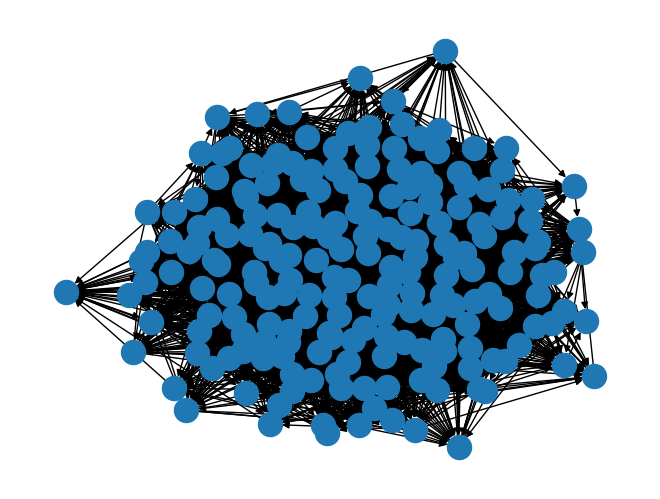

In [5]:
rw.show_sample()

In [158]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.histplot(degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

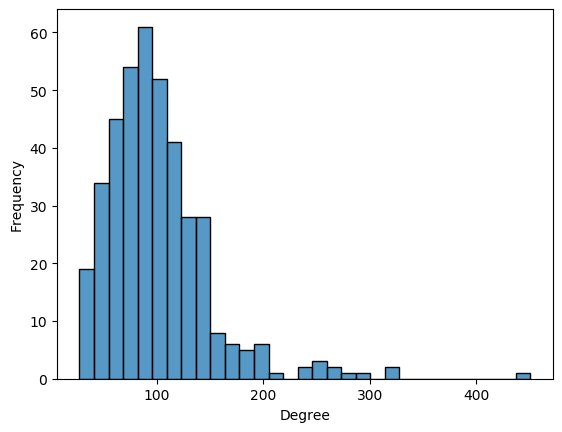

In [11]:
plot_degree_dist(sample)

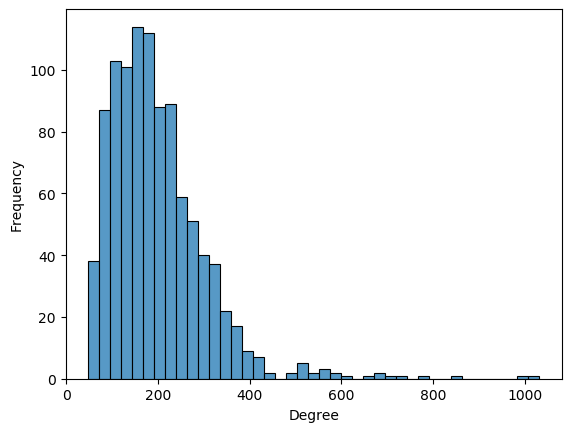

In [16]:
plot_degree_dist(G2)

In [12]:
def plot_degree_dist_per_group(G, attribute=''):
    group_0 = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == 0]
    group_1 = [G.degree(n[0]) for n in G.nodes(data=True) if n[-1][attribute] == 1]
    
    plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
    plt.hist(group_0)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.title('group_0')
    plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
    plt.hist(group_1)
    plt.xlabel('Degree')
    plt.title('group_1')

    plt.show()

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.histplot(degrees)
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

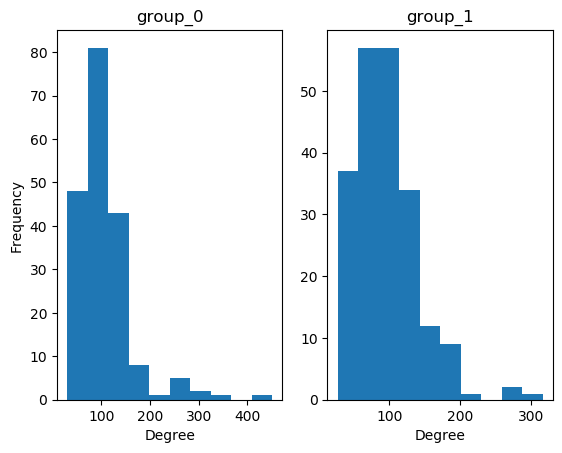

In [13]:
plot_degree_dist_per_group(sample, attribute='_class')

In [14]:
print(nx.average_shortest_path_length(G2))

1.9433073073073073


In [15]:
print(nx.average_shortest_path_length(sample))

1.922625313283208


----------------------------------------------------------------------------------------------------

In [103]:
# EXPERIMENTAL

SAMPLE_SIZE = 100

all_nodes  = [n for n in G.nodes()]
k_0 = np.random.choice(all_nodes, 1)[0]

sampled_network = nx.DiGraph()

for i in range(SAMPLE_SIZE):
    
    out_edges_k0 = [tup[1] for tup in G.out_edges(k_0)]
    
    traversion_proba = np.random.randint(1, 100)

    if traversion_proba <= 85:
        if len(out_edges_k0) > 0:
            k_1 = np.random.choice(out_edges_k0, 1)[0]
            sampled_network.add_edge(k_0, k_1)
        else:
            sampled_network.add_node(k_0)
            k_1 = np.random.choice(all_nodes, 1)[0]
    
    else:
        k_1 = np.random.choice(all_nodes, 1)[0]
        sampled_network.add_node(k_1)
        sampled_network.add_node(k_0)

    k_0 = k_1
    


In [57]:
aG = DPA(N=1000, 
        fm=0.5, 
        d=0.01, 
        plo_M=2.5, 
        plo_m=2.5,
        verbose=False)

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


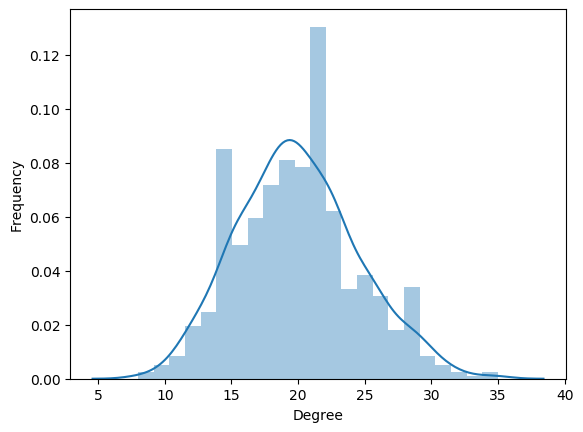

In [70]:
plot_degree_dist(G)

C:\Users\timod\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


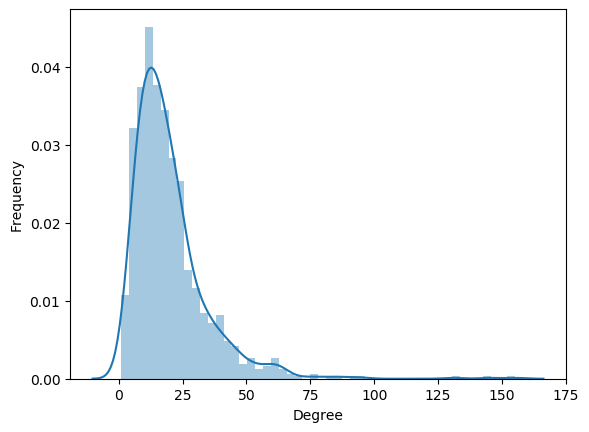

In [64]:
plot_degree_dist(aG)